<a href="https://colab.research.google.com/github/BaltiAhmed/TradingBot-LSTM/blob/main/LSTM_Scalping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- Import des librairies ---
!pip install pandas numpy matplotlib seaborn plotly tensorflow python-binance backtrader


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.4/136.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 33.8 MB/s eta 0:00:00


# Étape 1 – Chargement des données

In [ ]:
# Imports de base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# (optionnel si tu veux de l’interactif)
import plotly.express as px


In [ ]:

import pandas as pd

# --- Charger ton fichier CSV (upload depuis ton PC vers Colab) ---
from google.colab import files
uploaded = files.upload()   # choisis "klines_BTCUSDT_1m_mainnet_last365days.csv"

# --- Lire le fichier CSV ---
df = pd.read_csv("klines_BTCUSDT_1m_mainnet_last365days.csv")

# --- Conversion de la date ---
df['open_time_utc'] = pd.to_datetime(df['open_time_utc'])

# --- Sélection des colonnes essentielles ---
df = df[['open_time_utc', 'open', 'high', 'low', 'close', 'volume']]

# --- Mettre l’horodatage comme index ---
df.set_index('open_time_utc', inplace=True)

# --- Conversion en float ---
df = df.astype(float)

# --- Aperçu ---
print("Shape:", df.shape)
print(df.head())
print(df.info())


Saving klines_BTCUSDT_1m_mainnet_last365days.csv to klines_BTCUSDT_1m_mainnet_last365days.csv
Shape: (525600, 5)
                               open      high       low     close    volume
open_time_utc                                                              
2024-09-18 21:32:00+00:00  60361.50  60367.50  60328.76  60335.99  12.32316
2024-09-18 21:33:00+00:00  60335.99  60372.89  60335.99  60372.89  10.64060
2024-09-18 21:34:00+00:00  60372.89  60372.89  60354.00  60363.64   5.64400
2024-09-18 21:35:00+00:00  60363.63  60390.63  60363.63  60390.63   2.24468
2024-09-18 21:36:00+00:00  60390.63  60400.00  60384.00  60399.99  12.75325
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 525600 entries, 2024-09-18 21:32:00+00:00 to 2025-09-18 21:31:00+00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    525600 non-null  float64
 1   high    525600 non-null  float64
 2   low     525600 non-null  float64
 3   clos

# Étape 2 – Exploration & Indicateurs techniques

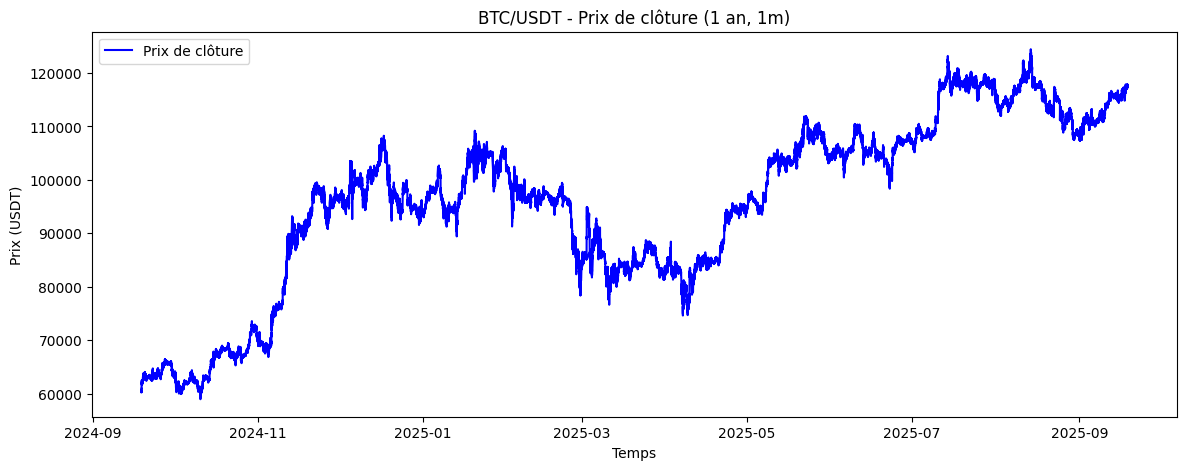

In [ ]:
import matplotlib.pyplot as plt

# --- Tracer le prix de clôture sur 1 an ---
plt.figure(figsize=(14,5))
plt.plot(df.index, df['close'], label="Prix de clôture", color="blue")
plt.title("BTC/USDT - Prix de clôture (1 an, 1m)")
plt.xlabel("Temps")
plt.ylabel("Prix (USDT)")
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd

# SMA (Simple Moving Average)
df["SMA_20"] = df["close"].rolling(window=20).mean()

# EMA (Exponential Moving Average)
df["EMA_20"] = df["close"].ewm(span=20, adjust=False).mean()

# RSI (Relative Strength Index, 14 périodes)
delta = df["close"].diff()
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)
avg_gain = pd.Series(gain).rolling(window=14).mean()
avg_loss = pd.Series(loss).rolling(window=14).mean()
rs = avg_gain / avg_loss
df["RSI_14"] = 100 - (100 / (1 + rs))

# Bandes de Bollinger (20 périodes)
df["BB_middle"] = df["close"].rolling(window=20).mean()
df["BB_std"] = df["close"].rolling(window=20).std()
df["BB_upper"] = df["BB_middle"] + 2*df["BB_std"]
df["BB_lower"] = df["BB_middle"] - 2*df["BB_std"]

# Vérification
print(df.tail(5))


                                open       high        low      close  \
open_time_utc                                                           
2025-09-18 21:27:00+00:00  117382.43  117437.99  117382.42  117437.98   
2025-09-18 21:28:00+00:00  117437.98  117437.99  117437.98  117437.98   
2025-09-18 21:29:00+00:00  117437.98  117437.99  117437.98  117437.98   
2025-09-18 21:30:00+00:00  117437.98  117438.00  117424.36  117438.00   
2025-09-18 21:31:00+00:00  117437.99  117438.00  117437.99  117437.99   

                            volume       SMA_20         EMA_20  RSI_14  \
open_time_utc                                                            
2025-09-18 21:27:00+00:00  5.10019  117375.6515  117396.885208     NaN   
2025-09-18 21:28:00+00:00  0.46756  117379.4830  117400.798998     NaN   
2025-09-18 21:29:00+00:00  0.88151  117382.7280  117404.340046     NaN   
2025-09-18 21:30:00+00:00  4.54159  117385.9735  117407.545756     NaN   
2025-09-18 21:31:00+00:00  1.78884  117388.8

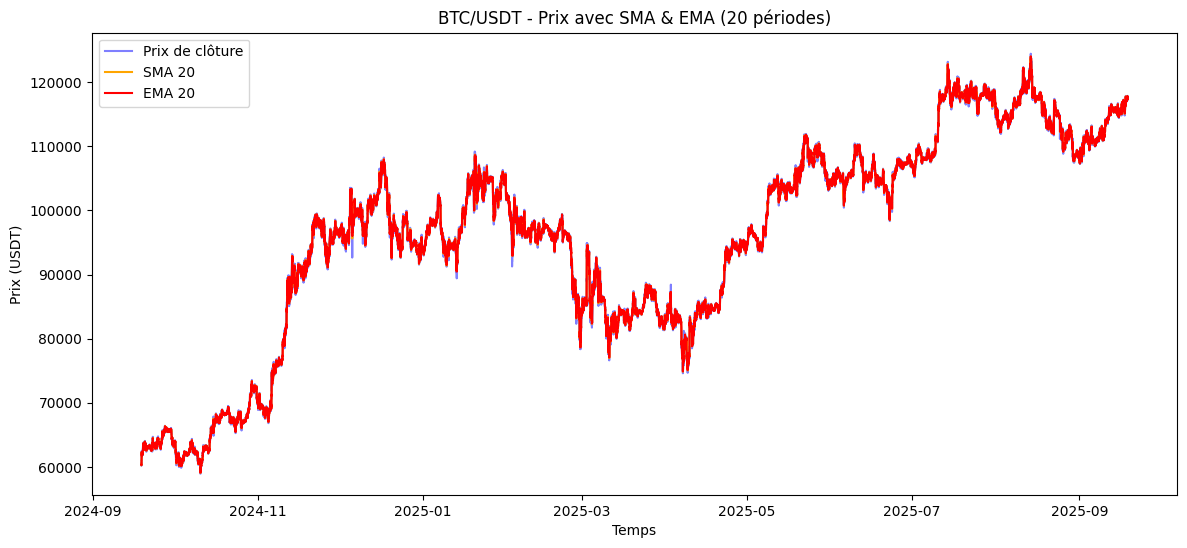

In [ ]:
# --- Visualisation SMA & EMA sur les prix ---
plt.figure(figsize=(14,6))
plt.plot(df.index, df['close'], label="Prix de clôture", color="blue", alpha=0.5)
plt.plot(df.index, df['SMA_20'], label="SMA 20", color="orange")
plt.plot(df.index, df['EMA_20'], label="EMA 20", color="red")
plt.title("BTC/USDT - Prix avec SMA & EMA (20 périodes)")
plt.xlabel("Temps")
plt.ylabel("Prix (USDT)")
plt.legend()
plt.show()

In [ ]:
!pip install ta


                               close     RSI_14
open_time_utc                                  
2025-09-18 21:12:00+00:00  117379.99  26.247917
2025-09-18 21:13:00+00:00  117380.00  26.251883
2025-09-18 21:14:00+00:00  117330.02  20.358877
2025-09-18 21:15:00+00:00  117338.71  23.571360
2025-09-18 21:16:00+00:00  117380.90  36.882812
2025-09-18 21:17:00+00:00  117380.90  36.882812
2025-09-18 21:18:00+00:00  117350.90  32.250602
2025-09-18 21:19:00+00:00  117372.19  38.184009
2025-09-18 21:20:00+00:00  117400.00  44.964368
2025-09-18 21:21:00+00:00  117405.67  46.258645
2025-09-18 21:22:00+00:00  117390.23  43.274215
2025-09-18 21:23:00+00:00  117368.01  39.340608
2025-09-18 21:24:00+00:00  117355.02  37.211078
2025-09-18 21:25:00+00:00  117372.58  41.797602
2025-09-18 21:26:00+00:00  117382.42  44.254926
2025-09-18 21:27:00+00:00  117437.98  55.642692
2025-09-18 21:28:00+00:00  117437.98  55.642692
2025-09-18 21:29:00+00:00  117437.98  55.642692
2025-09-18 21:30:00+00:00  117438.00  55

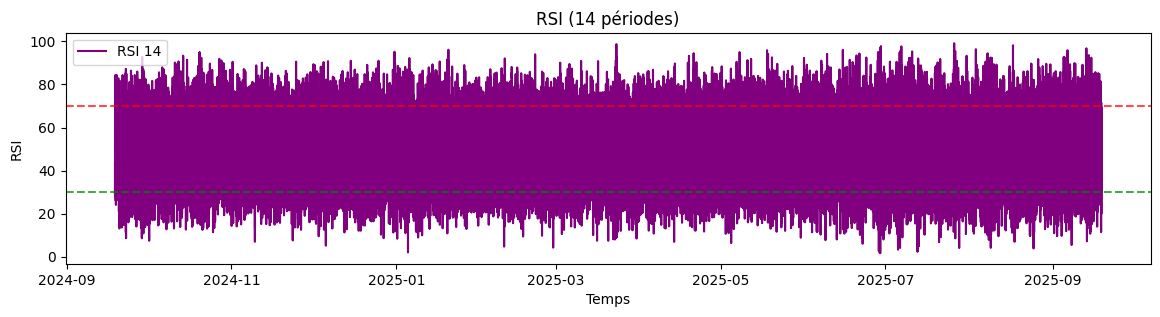

In [ ]:
import ta

# RSI avec la librairie ta
df["RSI_14"] = ta.momentum.RSIIndicator(df["close"], window=14).rsi()

# Vérification rapide
print(df[["close", "RSI_14"]].tail(20))

# Nouveau tracé
plt.figure(figsize=(14,3))
plt.plot(df.index, df['RSI_14'], label="RSI 14", color="purple")
plt.axhline(70, linestyle="--", color="red", alpha=0.7)   # Surachat
plt.axhline(30, linestyle="--", color="green", alpha=0.7) # Survente
plt.title("RSI (14 périodes)")
plt.xlabel("Temps")
plt.ylabel("RSI")
plt.legend()
plt.show()


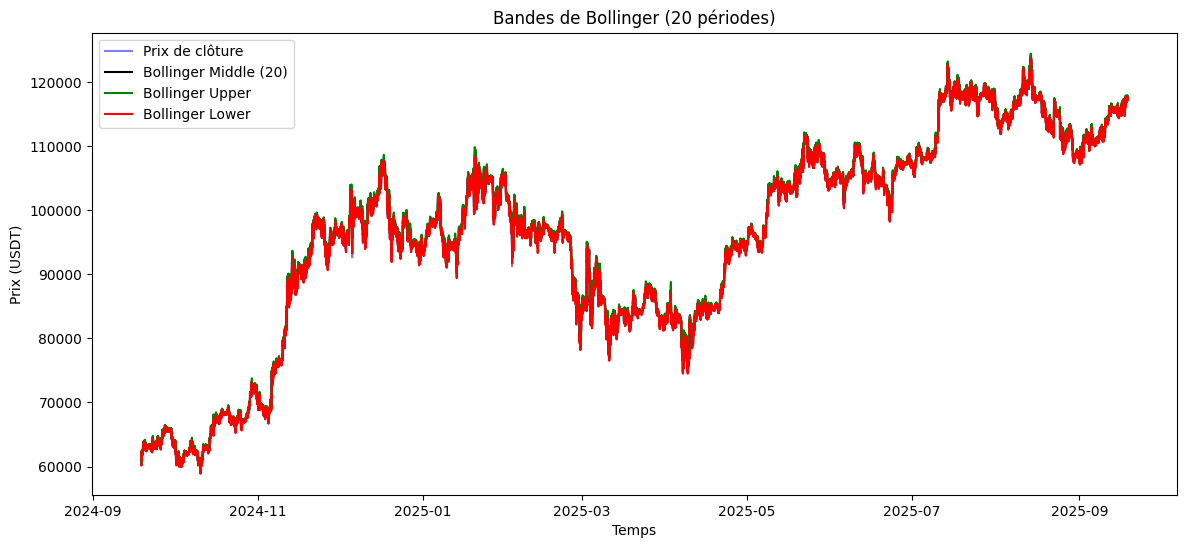

In [ ]:
# --- Visualisation Bandes de Bollinger ---
plt.figure(figsize=(14,6))
plt.plot(df.index, df['close'], label="Prix de clôture", color="blue", alpha=0.5)
plt.plot(df.index, df['BB_middle'], label="Bollinger Middle (20)", color="black")
plt.plot(df.index, df['BB_upper'], label="Bollinger Upper", color="green")
plt.plot(df.index, df['BB_lower'], label="Bollinger Lower", color="red")
plt.fill_between(df.index, df['BB_lower'], df['BB_upper'], color="gray", alpha=0.1)
plt.title("Bandes de Bollinger (20 périodes)")
plt.xlabel("Temps")
plt.ylabel("Prix (USDT)")
plt.legend()
plt.show()

In [ ]:
import ta

# === Ajout des indicateurs directionnels ===
macd = ta.trend.MACD(df['close'])
df['macd'] = macd.macd()
df['macd_signal'] = macd.macd_signal()
df['macd_hist'] = macd.macd_diff()

adx = ta.trend.ADXIndicator(df['high'], df['low'], df['close'], window=14)
df['adx'] = adx.adx()

sto = ta.momentum.StochasticOscillator(df['high'], df['low'], df['close'], window=14, smooth_window=3)
df['sto_k'] = sto.stoch()
df['sto_d'] = sto.stoch_signal()

atr = ta.volatility.AverageTrueRange(df['high'], df['low'], df['close'], window=14)
df['atr_14'] = atr.average_true_range()

# Nettoyage
df.fillna(method='bfill', inplace=True)
df.fillna(0, inplace=True)


/tmp/ipython-input-2071153610.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


In [ ]:

from google.colab import drive
drive.mount('/content/drive')

# 🆕 Sauvegarde en CSV (version enrichie)
df.to_csv("/content/drive/MyDrive/BTC_1m_preprocessed_v2.csv", index=False)

# 🆕 Sauvegarde en Pickle (plus rapide à recharger)
df.to_pickle("/content/drive/MyDrive/BTC_1m_preprocessed_v2.pkl")

print("✅ Nouveau dataset enrichi sauvegardé sous : BTC_1m_preprocessed_v2.csv et .pkl")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Nouveau dataset enrichi sauvegardé sous : BTC_1m_preprocessed_v2.csv et .pkl


In [ ]:
import pandas as pd
df = pd.read_pickle("/content/drive/MyDrive/BTC_1m_preprocessed_v2.pkl")
print(df.shape)
df.head()


(525600, 19)


,open,high,low,close,volume,SMA_20,EMA_20,RSI_14,BB_middle,BB_std,BB_upper,BB_lower,macd,macd_signal,macd_hist,adx,sto_k,sto_d,atr_14
open_time_utc,,,,,,,,,,,,,,,,,,,
2024-09-18 21:32:00+00:00,60361.50,60367.50,60328.76,60335.99,12.32316,60348.941,60335.990000,43.388406,60348.941,71.141933,60491.224867,60206.657133,-27.334265,-23.189578,12.629575,0.0,3.371187,1.125639,0.0
2024-09-18 21:33:00+00:00,60335.99,60372.89,60335.99,60372.89,10.64060,60348.941,60339.504286,43.388406,60348.941,71.141933,60491.224867,60206.657133,-27.334265,-23.189578,12.629575,0.0,3.371187,1.125639,0.0
2024-09-18 21:34:00+00:00,60372.89,60372.89,60354.00,60363.64,5.64400,60348.941,60341.802925,43.388406,60348.941,71.141933,60491.224867,60206.657133,-27.334265,-23.189578,12.629575,0.0,3.371187,1.125639,0.0
2024-09-18 21:35:00+00:00,60363.63,60390.63,60363.63,60390.63,2.24468,60348.941,60346.453123,43.388406,60348.941,71.141933,60491.224867,60206.657133,-27.334265,-23.189578,12.629575,0.0,3.371187,1.125639,0.0
2024-09-18 21:36:00+00:00,60390.63,60400.00,60384.00,60399.99,12.75325,60348.941,60351.551873,43.388406,60348.941,71.141933,60491.224867,60206.657133,-27.334265,-23.189578,12.629575,0.0,3.371187,1.125639,0.0


# Étape 3 – Prétraitement

In [ ]:
# Création des df_features,on garde uniquement les colonnes utiles pour l'entraînement
features = [
    'open', 'high', 'low', 'close', 'volume',
    'EMA_20', 'RSI_14', 'BB_middle', 'BB_std', 'BB_upper', 'BB_lower',
    'macd', 'macd_signal', 'macd_hist', 'adx', 'sto_k', 'sto_d', 'atr_14'
]
df_features = df[features].dropna().copy()  # dropna car indicateurs techniques au début sont NaN

print("Shape après sélection :", df_features.shape)
df_features.head()


Shape après sélection : (525600, 18)


,open,high,low,close,volume,EMA_20,RSI_14,BB_middle,BB_std,BB_upper,BB_lower,macd,macd_signal,macd_hist,adx,sto_k,sto_d,atr_14
open_time_utc,,,,,,,,,,,,,,,,,,
2024-09-18 21:32:00+00:00,60361.50,60367.50,60328.76,60335.99,12.32316,60335.990000,43.388406,60348.941,71.141933,60491.224867,60206.657133,-27.334265,-23.189578,12.629575,0.0,3.371187,1.125639,0.0
2024-09-18 21:33:00+00:00,60335.99,60372.89,60335.99,60372.89,10.64060,60339.504286,43.388406,60348.941,71.141933,60491.224867,60206.657133,-27.334265,-23.189578,12.629575,0.0,3.371187,1.125639,0.0
2024-09-18 21:34:00+00:00,60372.89,60372.89,60354.00,60363.64,5.64400,60341.802925,43.388406,60348.941,71.141933,60491.224867,60206.657133,-27.334265,-23.189578,12.629575,0.0,3.371187,1.125639,0.0
2024-09-18 21:35:00+00:00,60363.63,60390.63,60363.63,60390.63,2.24468,60346.453123,43.388406,60348.941,71.141933,60491.224867,60206.657133,-27.334265,-23.189578,12.629575,0.0,3.371187,1.125639,0.0
2024-09-18 21:36:00+00:00,60390.63,60400.00,60384.00,60399.99,12.75325,60351.551873,43.388406,60348.941,71.141933,60491.224867,60206.657133,-27.334265,-23.189578,12.629575,0.0,3.371187,1.125639,0.0


In [ ]:
#Labeling : définir la logique de Buy/Sell/Hold

horizon = 3  # nombre de minutes à prévoir
threshold = 0.002  # 0.2% mouvement

# On garde uniquement les colonnes utiles pour l'entraînement
features = [
    'open', 'high', 'low', 'close', 'volume',
    'EMA_20', 'RSI_14', 'BB_middle', 'BB_std', 'BB_upper', 'BB_lower',
    'macd', 'macd_signal', 'macd_hist', 'adx', 'sto_k', 'sto_d', 'atr_14'
]
df_features = df[features].dropna().copy()  # dropna car indicateurs techniques au début sont NaN


df_features["future_close"] = df["close"].shift(-horizon)

df_features["label"] = 0
df_features.loc[(df_features["future_close"] - df_features["close"]) / df_features["close"] > threshold, "label"] = 1
df_features.loc[(df_features["future_close"] - df_features["close"]) / df_features["close"] < -threshold, "label"] = -1

# Remap labels -1, 0, 1 to 0, 1, 2 for sparse_categorical_crossentropy
label_mapping = {-1: 0, 0: 1, 1: 2}
df_features["label"] = df_features["label"].map(label_mapping)


# Supprimer les dernières lignes qui n'ont pas de future_close
df_features = df_features.dropna()

print(df_features["label"].value_counts())
df_features.head(15)

label
1    492597
2     16580
0     16420
Name: count, dtype: int64


,open,high,low,close,volume,EMA_20,RSI_14,BB_middle,BB_std,BB_upper,BB_lower,macd,macd_signal,macd_hist,adx,sto_k,sto_d,atr_14,future_close,label
open_time_utc,,,,,,,,,,,,,,,,,,,,
2024-09-18 21:32:00+00:00,60361.50,60367.50,60328.76,60335.99,12.32316,60335.990000,43.388406,60348.941,71.141933,60491.224867,60206.657133,-27.334265,-23.189578,12.629575,0.0,3.371187,1.125639,0.000000,60390.63,1
2024-09-18 21:33:00+00:00,60335.99,60372.89,60335.99,60372.89,10.64060,60339.504286,43.388406,60348.941,71.141933,60491.224867,60206.657133,-27.334265,-23.189578,12.629575,0.0,3.371187,1.125639,0.000000,60399.99,1
2024-09-18 21:34:00+00:00,60372.89,60372.89,60354.00,60363.64,5.64400,60341.802925,43.388406,60348.941,71.141933,60491.224867,60206.657133,-27.334265,-23.189578,12.629575,0.0,3.371187,1.125639,0.000000,60432.01,1
2024-09-18 21:35:00+00:00,60363.63,60390.63,60363.63,60390.63,2.24468,60346.453123,43.388406,60348.941,71.141933,60491.224867,60206.657133,-27.334265,-23.189578,12.629575,0.0,3.371187,1.125639,0.000000,60414.79,1
2024-09-18 21:36:00+00:00,60390.63,60400.00,60384.00,60399.99,12.75325,60351.551873,43.388406,60348.941,71.141933,60491.224867,60206.657133,-27.334265,-23.189578,12.629575,0.0,3.371187,1.125639,0.000000,60480.00,1
2024-09-18 21:37:00+00:00,60399.99,60450.02,60399.99,60432.01,47.22143,60359.214552,43.388406,60348.941,71.141933,60491.224867,60206.657133,-27.334265,-23.189578,12.629575,0.0,3.371187,1.125639,0.000000,60420.80,1
2024-09-18 21:38:00+00:00,60432.01,60466.66,60414.78,60414.79,13.32958,60364.507452,43.388406,60348.941,71.141933,60491.224867,60206.657133,-27.334265,-23.189578,12.629575,0.0,3.371187,1.125639,0.000000,60366.27,1
2024-09-18 21:39:00+00:00,60414.79,60496.95,60414.78,60480.00,32.66446,60375.506742,43.388406,60348.941,71.141933,60491.224867,60206.657133,-27.334265,-23.189578,12.629575,0.0,3.371187,1.125639,0.000000,60383.59,1
2024-09-18 21:40:00+00:00,60480.64,60485.18,60390.77,60420.80,27.28240,60379.820386,43.388406,60348.941,71.141933,60491.224867,60206.657133,-27.334265,-23.189578,12.629575,0.0,3.371187,1.125639,0.000000,60388.13,1


In [ ]:
# transformer les données en séquences pour LSTM.
import numpy as np

# Paramètres
seq_len = 20  # taille de la fenêtre temporelle
features = [
    'open', 'high', 'low', 'close', 'volume',
    'EMA_20', 'RSI_14', 'BB_middle', 'BB_std', 'BB_upper', 'BB_lower',
    'macd', 'macd_signal', 'macd_hist', 'adx', 'sto_k', 'sto_d', 'atr_14'
]
# On convertit en numpy pour accélérer
data = df_features[features].values
labels = df_features["label"].values

X, y = [], []

for i in range(len(data) - seq_len):
    X.append(data[i:i+seq_len])   # séquence de 20 bougies
    y.append(labels[i+seq_len])   # label associé à la fin de la séquence

X = np.array(X)
y = np.array(y)

print("Shape X :", X.shape)  # (nb_samples, 20, nb_features)
print("Shape y :", y.shape)  # (nb_samples,)


Shape X : (525577, 20, 18)
Shape y : (525577,)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Etape 4 : préparation du dataset pour LSTM.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Découpagedes données train/test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    shuffle=False  # respect de la chronologie
)

print("Shapes après split :")
print("X_train :", X_train.shape, "y_train :", y_train.shape)
print("X_test :", X_test.shape, "y_test :", y_test.shape)

print("\nRépartition des classes (avant oversampling) :")
print("Train :", np.bincount(y_train))
print("Test  :", np.bincount(y_test))
# ⚠️ Normalisation : on scale seulement sur le TRAIN pour éviter data leakage(toutes les colonnes doivent être sur la même échelle)
scalers = []
X_train_scaled = np.zeros_like(X_train)
X_test_scaled = np.zeros_like(X_test)

for i in range(X_train.shape[2]):  # chaque feature séparément
    scaler = StandardScaler()
    X_train_scaled[:, :, i] = scaler.fit_transform(X_train[:, :, i])
    X_test_scaled[:, :, i] = scaler.transform(X_test[:, :, i])
    scalers.append(scaler)

print("\n✅ Normalisation terminée")
print("Nouvelle shape train:", X_train_scaled.shape)

Shapes après split :
X_train : (420461, 20, 18) y_train : (420461,)
X_test : (105116, 20, 18) y_test : (105116,)

Répartition des classes (avant oversampling) :
Train : [ 15235 389865  15361]
Test  : [  1185 102712   1219]

✅ Normalisation terminée
Nouvelle shape train: (420461, 20, 18)


In [ ]:
X_train_balanced, y_train_balanced = [], []

max_class = np.max(np.bincount(y_train))
target_samples = int(0.5 * max_class)  # Oversampling à mi-chemin

# Séparer par classe
for label in np.unique(y_train):
    X_class = X_train_scaled[y_train == label]
    y_class = y_train[y_train == label]

    # Oversampling limité
    X_res, y_res = resample(
        X_class, y_class,
        replace=True,
        n_samples=target_samples,
        random_state=42
    )
    X_train_balanced.append(X_res)
    y_train_balanced.append(y_res)

# Fusion
X_train_balanced = np.vstack(X_train_balanced)
y_train_balanced = np.hstack(y_train_balanced)

print("\nNouvelle distribution après oversampling :")
print(np.bincount(y_train_balanced))



Nouvelle distribution après oversampling :
[194932 194932 194932]


In [ ]:
# ⚖️ Calcul des class weight
from sklearn.utils.class_weight import compute_class_weight

# Vérification existence variables
print("Existence des variables :")
print(" - X_train_balanced :", "X_train_balanced" in globals())
print(" - y_train_balanced :", "y_train_balanced" in globals())
print(" - X_test_scaled :", "X_test_scaled" in globals())
print(" - y_test :", "y_test" in globals())

# Conversion en int
y_train_balanced = np.array(y_train_balanced).astype(int)

# Calcul des poids de classes
classes = np.unique(y_train_balanced)
class_weights_values = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train_balanced
)

# Dictionnaire attendu par Keras
class_weights = {int(c): float(w) for c, w in zip(classes, class_weights_values)}

print("\n✅ Class weights calculés :")
print(class_weights)


Existence des variables :
 - X_train_balanced : True
 - y_train_balanced : True
 - X_test_scaled : True
 - y_test : True

✅ Class weights calculés :
{0: 1.0, 1: 1.0, 2: 1.0}


# Construction du modèle Bidirectional LSTM

In [ ]:
from tensorflow.keras import backend as K
import tensorflow as tf

def focal_loss(gamma=2., alpha=1.):
    def focal_loss_fixed(y_true, y_pred):
        # S'assure que y_true est en int32 et a la bonne forme
        y_true = tf.reshape(tf.cast(y_true, tf.int32), [-1])
        y_true_onehot = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])

        # Clip pour stabilité numérique
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())

        # Calcul de la focal loss
        cross_entropy = -y_true_onehot * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = K.sum(weight * cross_entropy, axis=1)

        return K.mean(loss)
    return focal_loss_fixed


In [ ]:
print("Shape de X_train_balanced :", X_train_balanced.shape)


Shape de X_train_balanced : (584796, 20, 18)


In [ ]:
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras import backend as K


In [ ]:
from tensorflow.keras import metrics
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense

# Modèle LSTM
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, input_shape=(X_train_balanced.shape[1], X_train_balanced.shape[2]))),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    Dense(3, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss=focal_loss(gamma=2., alpha=1.),
    metrics=[metrics.SparseCategoricalAccuracy(name="accuracy")]
)

model.build(input_shape=(None, X_train_balanced.shape[1], X_train_balanced.shape[2]))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 20, 128)        │        42,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,907 (327.76 KB)

 Trainable params: 83,907 (327.76 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Calcul des class weights
#class_weights_values = compute_class_weight(
   # class_weight='balanced',
   # classes=np.unique(y_train_balanced),
   # y=y_train_balanced
#)
##class_weights = dict(enumerate(class_weights_values))

#print(" Class weights calculés :", class_weights)


In [ ]:
print("y_train_balanced shape:", y_train_balanced.shape)
print("y_test shape:", y_test.shape)


y_train_balanced shape: (584796,)
y_test shape: (105116,)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Callback EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Entraînement
history = model.fit(
    X_train_balanced, y_train_balanced,
    validation_data=(X_test_scaled, y_test),
    epochs=10,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)

NameError: name 'model' is not defined

# Evaluation

3285/3285 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step
📊 Rapport de classification :
              precision    recall  f1-score   support

        Sell       0.03      0.18      0.06      1185
        Hold       0.98      0.88      0.93    102708
         Buy       0.04      0.22      0.06      1219

    accuracy                           0.86    105112
   macro avg       0.35      0.42      0.35    105112
weighted avg       0.96      0.86      0.91    105112



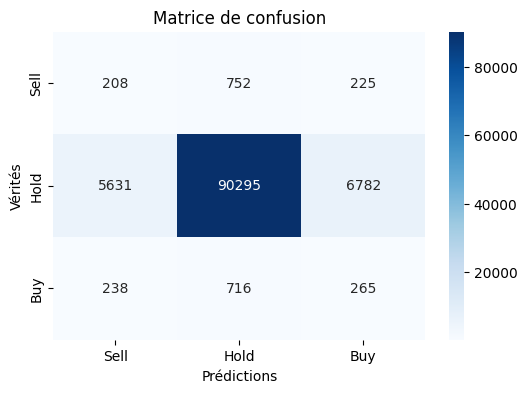

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Évaluation sur le test set
y_pred = model.predict(X_test_scaled)
y_pred_classes = y_pred.argmax(axis=1)

print("📊 Rapport de classification :")
print(classification_report(y_test, y_pred_classes, target_names=["Sell", "Hold", "Buy"]))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Sell","Hold","Buy"],
            yticklabels=["Sell","Hold","Buy"])
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.title("Matrice de confusion")
plt.show()
